In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/LU-FU.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
sheet.columns

last_day = sheet['LU-FU（期货指数）'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,LU-FU（期货指数）,新加坡高低硫燃料油价差,LU-FU（期货指数）拟合残差/新加坡高低硫燃料油价差,山东汽柴油加权裂解价差,Brent-Dubai/7DMA,SC期货指数-Brent原油期货价格,brent-dubai价差
2025-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths = [
    os.path.expanduser("~/Desktop/X-BASE/燃料油/eta/新加坡高低硫燃料油价差_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/燃料油/eta/新加坡高低硫燃料油价差_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/燃料油/eta/新加坡高低硫燃料油价差_合并数据.xlsx")
]

file_path = None
for path in file_paths:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path = path
        break

if file_path is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['真实值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.tail()

,Date,预测值
4,2025-11-24,98.3
3,2025-11-25,97.9
2,2025-11-26,102.2
1,2025-11-27,96.6
0,2025-11-28,97.1


In [6]:
# 尝试多个可能的文件路径
file_paths2 = [
    os.path.expanduser("~/Desktop/X-BASE/wti模型3.0/eta/Brent-Dubai_合并数据.xlsx"),    
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/wti模型3.0/eta/Brent-Dubai_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/wti模型3.0/eta/Brent-Dubai_合并数据.xlsx")
]

file_path2 = None
for path in file_paths2:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path2 = path
        break

if file_path2 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet2 = pd.read_excel(file_path2, sheet_name='Sheet1')
    sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
    sheet2 = sheet2.drop(columns=['真实值'])
    sheet2 = sheet2.dropna()
    sheet2 = sheet2.sort_values('Date', ascending=True)
    sheet2.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")
sheet2.tail()

,Date,预测值
4,2025-12-08,-0.1
3,2025-12-09,-0.1
2,2025-12-10,-0.1
1,2025-12-11,-0.1
0,2025-12-12,-0.1


In [7]:
sheet3 = pd.ExcelFile('eta/山东柴油裂解差(多因子)_合并数据.xlsx').parse('Sheet1')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
sheet3 = sheet3.sort_values('Date', ascending=True)
sheet3 = sheet3.drop(columns=['真实值'])
sheet3 = sheet3.dropna()
sheet3.head()

,Date,预测值
19,2025-11-03,269.0
18,2025-11-04,263.3
17,2025-11-05,280.7
16,2025-11-06,309.3
15,2025-11-07,298.7


In [8]:
sheet4 = pd.ExcelFile('eta/汽油裂解差(多因子)_合并数据.xlsx').parse('Sheet1')
sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
sheet4 = sheet4.sort_values('Date', ascending=True)
sheet4 = sheet4.drop(columns=['真实值'])
sheet4 = sheet4.dropna()
sheet4.head()

,Date,预测值
19,2025-10-31,385.4
18,2025-11-03,443.1
17,2025-11-04,644.0
16,2025-11-05,599.8
15,2025-11-06,482.7


In [9]:
sheet5 = sheet2.copy()
sheet5['山东汽柴油加权裂解价'] = (sheet4['预测值'] + 2*sheet3['预测值']) / 3
sheet5.head()

,Date,预测值,山东汽柴油加权裂解价
29,2025-11-03,-0.1,NaN
28,2025-11-04,-0.2,NaN
27,2025-11-05,-0.2,NaN
26,2025-11-06,-0.2,NaN
25,2025-11-07,-0.2,NaN


In [10]:
sheet6 = pd.ExcelFile('eta/SC期货指数-Brent原油期货价格_合并数据.xlsx').parse('Sheet1')
sheet6['Date'] = pd.to_datetime(sheet6['Date'], errors='coerce')
sheet6 = sheet6.sort_values('Date', ascending=True)
sheet6 = sheet6.drop(columns=['真实值'])
sheet6 = sheet6.dropna()
sheet6.head()

,Date,预测值
20,2025-10-31,3.4
19,2025-11-03,1.1
18,2025-11-04,3.8
17,2025-11-05,2.1
16,2025-11-06,3.0


In [11]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['新加坡高低硫燃料油价差'] = sheet_daily['新加坡高低硫燃料油价差'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


sheet_daily = pd.merge(
    sheet_daily,
    sheet5[['Date', '山东汽柴油加权裂解价']],
    on='Date',
    how='left'
)
sheet_daily['山东汽柴油加权裂解价差'] = sheet_daily['山东汽柴油加权裂解价差'].fillna(sheet_daily['山东汽柴油加权裂解价'])
sheet_daily = sheet_daily.drop(columns=['山东汽柴油加权裂解价'])


sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['Brent-Dubai/7DMA'] = sheet_daily['Brent-Dubai/7DMA'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


sheet_daily = pd.merge(
    sheet_daily,
    sheet6[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['SC期货指数-Brent原油期货价格'] = sheet_daily['SC期货指数-Brent原油期货价格'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [12]:
sheet.columns

Index(['LU-FU（期货指数）', '新加坡高低硫燃料油价差', 'LU-FU（期货指数）拟合残差/新加坡高低硫燃料油价差',
       '山东汽柴油加权裂解价差', 'Brent-Dubai/7DMA', 'SC期货指数-Brent原油期货价格',
       'brent-dubai价差'],
      dtype='object')

In [13]:
################################# 处理缺失值 #################################
fill_methods = {
'新加坡高低硫燃料油价差':'interpolate', 
'山东汽柴油加权裂解价差':'interpolate', 
'Brent-Dubai/7DMA':'interpolate',
'SC期货指数-Brent原油期货价格':'interpolate',
'brent-dubai价差':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LU-FU（期货指数）拟合残差/新加坡高低硫燃料油价差'] = sheet.loc[:last_day, 'LU-FU（期货指数）拟合残差/新加坡高低硫燃料油价差'].interpolate(method='linear')


#################################  因子处理  #################################

'''
sheet['美国ISM制造业PMI\新订单比自有库存_提前60天'] = sheet['美国ISM制造业PMI\新订单比自有库存'].shift(60)

sheet['全球平均短端利率同差_提前240天_逆序'] = reverse_column(sheet, '全球平均短端利率同差_提前240天')
'''
sheet['brent-dubai价差_提前10天'] = sheet['brent-dubai价差'].shift(10)

# 获取最后20个数据点
last_20_points = sheet.tail(20)

# 处理每一列
for col in ['brent-dubai价差_提前10天']:
    # 找出重复值
    duplicates = last_20_points[col][last_20_points[col].duplicated(keep='first')]
    # 如果重复值超过3个,保留第一个出现的值,其他置为空
    if len(duplicates) >= 3:
        sheet.loc[sheet.index[-20:], col] = sheet.loc[sheet.index[-20:], col].mask(
            lambda x: x.duplicated(keep='first')
        )
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-03-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['LU-FU（期货指数）拟合残差/新加坡高低硫燃料油价差'].notna())
]

################################# 数据 读取-处理 结束 #################################

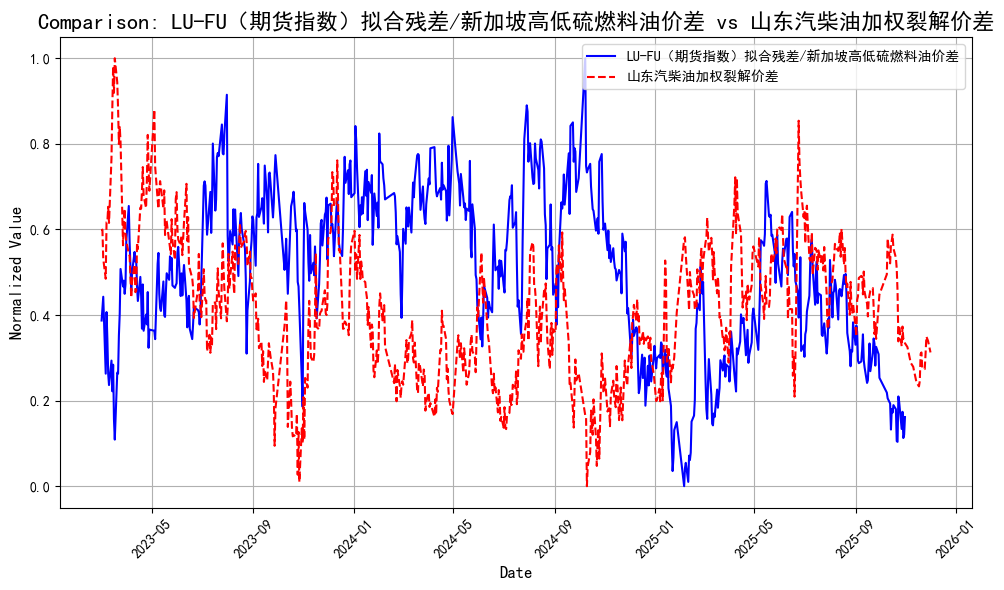

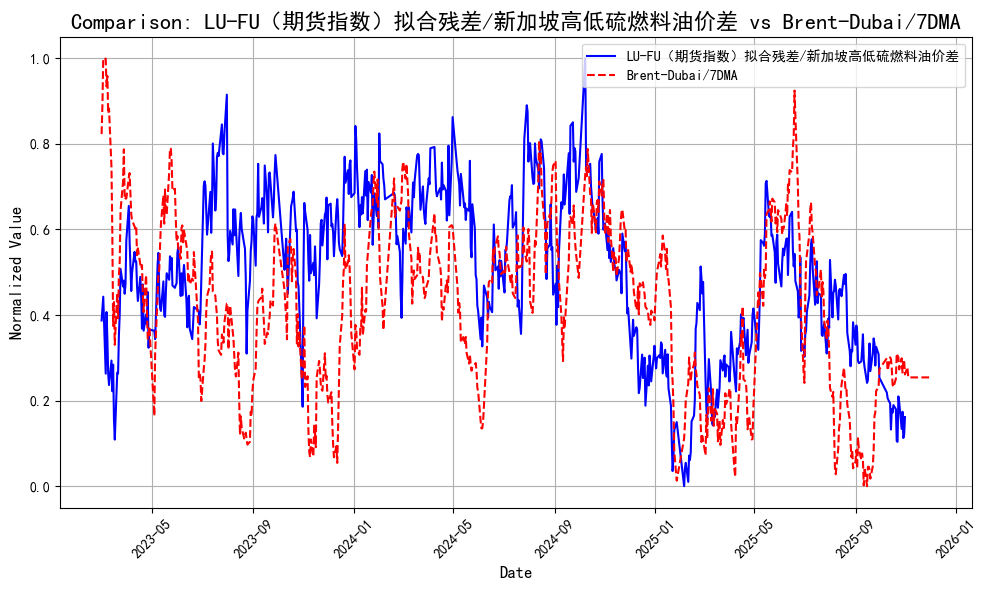

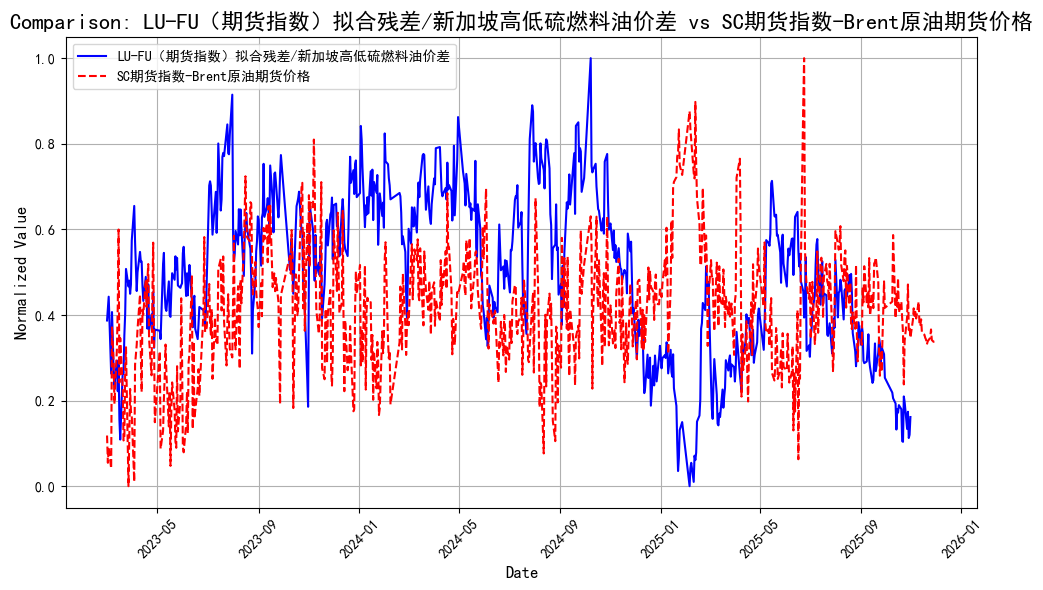

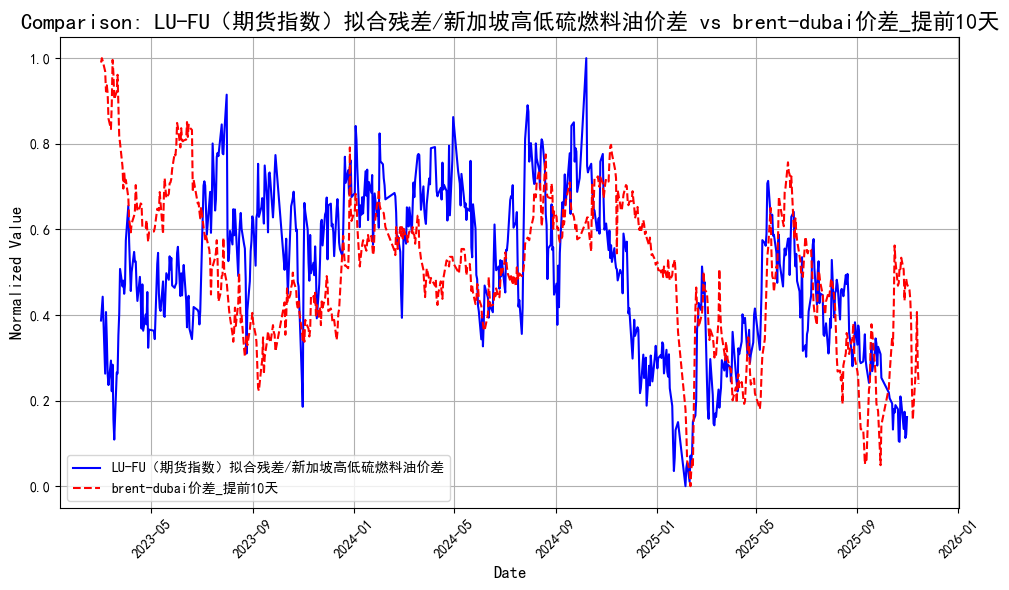

In [14]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='LU-FU（期货指数）拟合残差/新加坡高低硫燃料油价差', 
    compare_cols=[
        '山东汽柴油加权裂解价差',
        'Brent-Dubai/7DMA',
        'SC期货指数-Brent原油期货价格',
        'brent-dubai价差_提前10天'
        ]
)

In [15]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 30
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '山东汽柴油加权裂解价差',
        'Brent-Dubai/7DMA',
        'SC期货指数-Brent原油期货价格',
        'brent-dubai价差_提前10天'
]

predict_column = 'LU-FU（期货指数）拟合残差/新加坡高低硫燃料油价差'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 70)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
# 原参数
params = {
     'objective': 'reg:squarederror',  # 回归任务
     'learning_rate': 0.1,  # 较小的学习率
     'max_depth': 3,  # 控制树的深度防止过拟合
     'min_child_weight': 3,  # 控制过拟合
     'subsample': 0.7,  # 随机采样防止过拟合
     'colsample_bytree': 0.7,  # 特征随机采样
     'gamma': 0.4,  # 控制分裂
     'reg_alpha': 0.9,  # L1正则化
     'reg_lambda': 10,  # L2正则化
     'eval_metric': 'rmse', # 评估指标：选择"rmse"
     'seed': 42, # 随机种子
     'tree_method': 'auto'
 }



num_boost_round = 1000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:125.74960	train-rmse:63.96034


[500]	eval-rmse:125.12440	train-rmse:29.44931


[999]	eval-rmse:129.11666	train-rmse:20.80871


训练集 MSE (DMatrix): 508.911, 训练集 R² (DMatrix): 0.902
测试集 MSE (DMatrix): 16671.1111, 测试集 R² (DMatrix): -17.2713


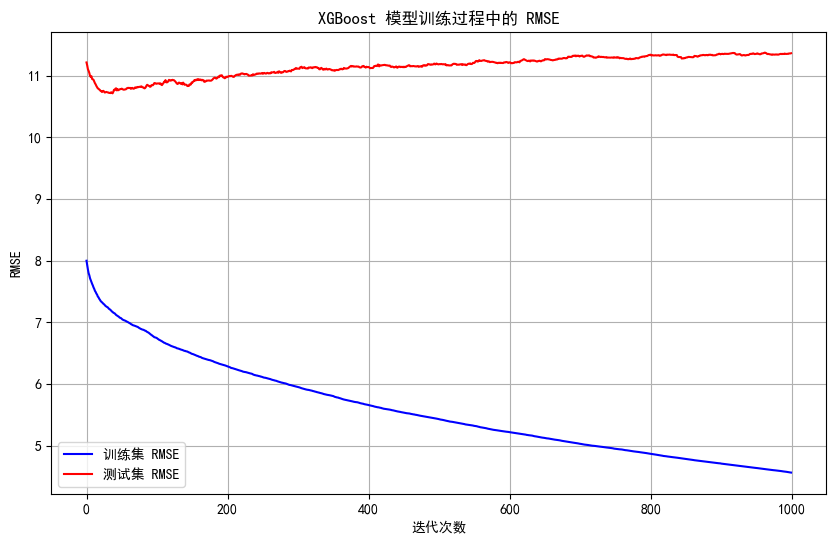

In [16]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:66.42696


[500]	train-rmse:31.44078


[999]	train-rmse:22.72092


全部数据 MSE: 626.6328, 全部数据 R²: 0.889


Gap between last actual value and first prediction: -125.7779983947754


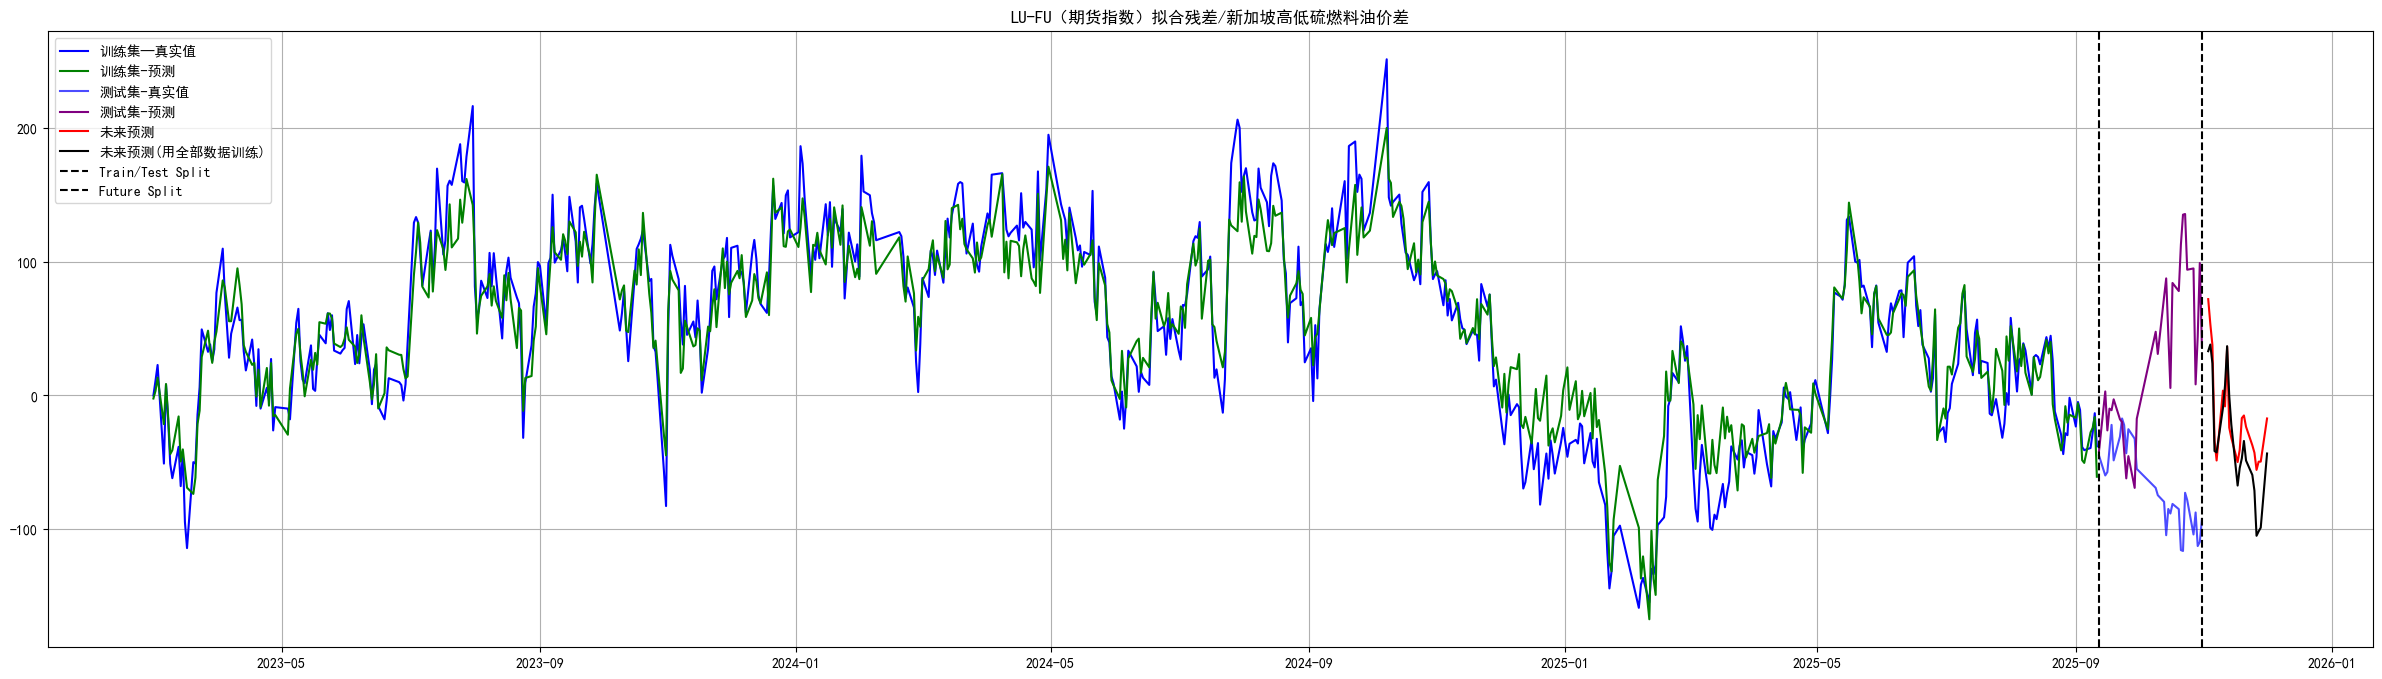

In [18]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('LU-FU（期货指数）拟合残差/新加坡高低硫燃料油价差')
plt.legend()
plt.grid(True)
plt.show()

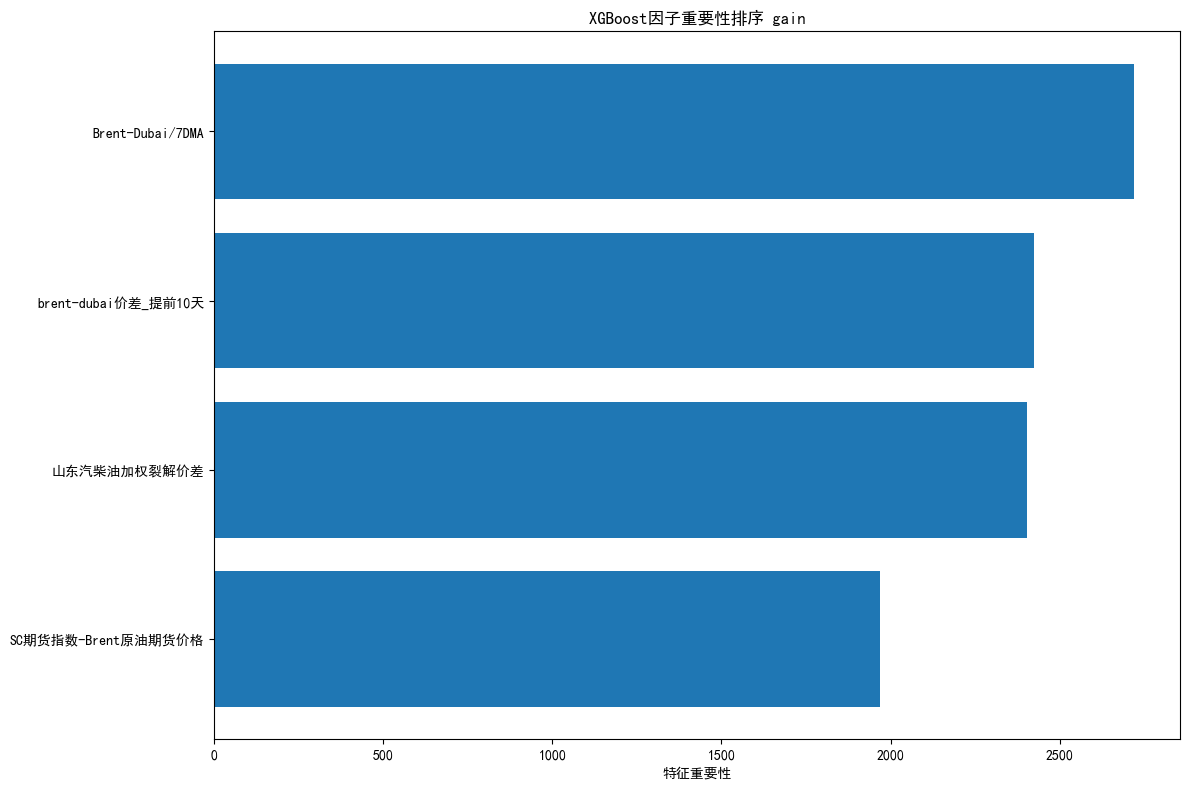

In [19]:

# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'gain'
feature_importance = model_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 gain')
plt.tight_layout()
plt.show()



---

In [20]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/LU-FU拟合残差_新加坡高低硫燃料油价差_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
668,2025/12/01,NaN,-43.660881
667,2025/11/28,NaN,-99.172707
666,2025/11/27,NaN,-101.970055
665,2025/11/26,NaN,-105.269112
664,2025/11/25,NaN,-71.512947
...,...,...,...
4,2023/03/07,7.8723,NaN
3,2023/03/06,-51.2137,NaN
2,2023/03/03,22.5922,NaN
1,2023/03/02,10.7863,NaN


In [21]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly = merged_df_monthly.round(2)
# 保存成excel
merged_df_monthly.to_excel('eta/LU-FU拟合残差_新加坡高低硫燃料油价差格_月度数据.xlsx', index=False, float_format='%.1f')

merged_df_monthly

,Date,真实值,预测值
33,2025/12/31,NaN,-43.660000
32,2025/11/30,NaN,-33.430000
31,2025/10/31,-91.85,71.269997
30,2025/09/30,-33.70,-28.870001
29,2025/08/31,14.32,11.280000
28,2025/07/31,13.57,26.389999
27,2025/06/30,48.28,47.889999
26,2025/05/31,70.65,71.330002
25,2025/04/30,-24.54,-21.150000
24,2025/03/31,-65.55,-34.340000


---

In [22]:
sheet_daily_combined = sheet_daily[['Date','新加坡高低硫燃料油价差','LU-FU（期货指数）']].copy()
sheet_daily_combined1 = merged_df_daily.copy()
sheet_daily_combined1['拟合'] = sheet_daily_combined1['真实值'].fillna(sheet_daily_combined1['预测值'])
sheet_daily_combined1[['Date', '拟合']]
sheet_daily_combined1 =sheet_daily_combined1.sort_values('Date', ascending=True)
sheet_daily_combined1 = sheet_daily_combined1.drop(columns=['真实值','预测值'])
sheet_daily_combined1['Date'] = pd.to_datetime(sheet_daily_combined1['Date'])
sheet_daily_combined = pd.merge(sheet_daily_combined, sheet_daily_combined1, on='Date', how='outer')
sheet_daily_combined = sheet_daily_combined.sort_values('Date')
sheet_daily_combined.head()

,Date,新加坡高低硫燃料油价差,LU-FU（期货指数）,拟合
0,2023-03-01,159.75,1110.0,-0.2359
1,2023-03-02,150.25,1067.0,10.7863
2,2023-03-03,143.25,1039.0,22.5922
3,2023-03-06,150.25,1005.0,-51.2137
4,2023-03-07,158.50,1111.0,7.8723


In [23]:
sheet_daily_combined['LU-FU_预测'] = 5.6866 * sheet_daily_combined['新加坡高低硫燃料油价差'] + 201.7992 + sheet_daily_combined['拟合']
sheet_daily_combined.head(2)

,Date,新加坡高低硫燃料油价差,LU-FU（期货指数）,拟合,LU-FU_预测
0,2023-03-01,159.75,1110.0,-0.2359,1109.99765
1,2023-03-02,150.25,1067.0,10.7863,1066.99715


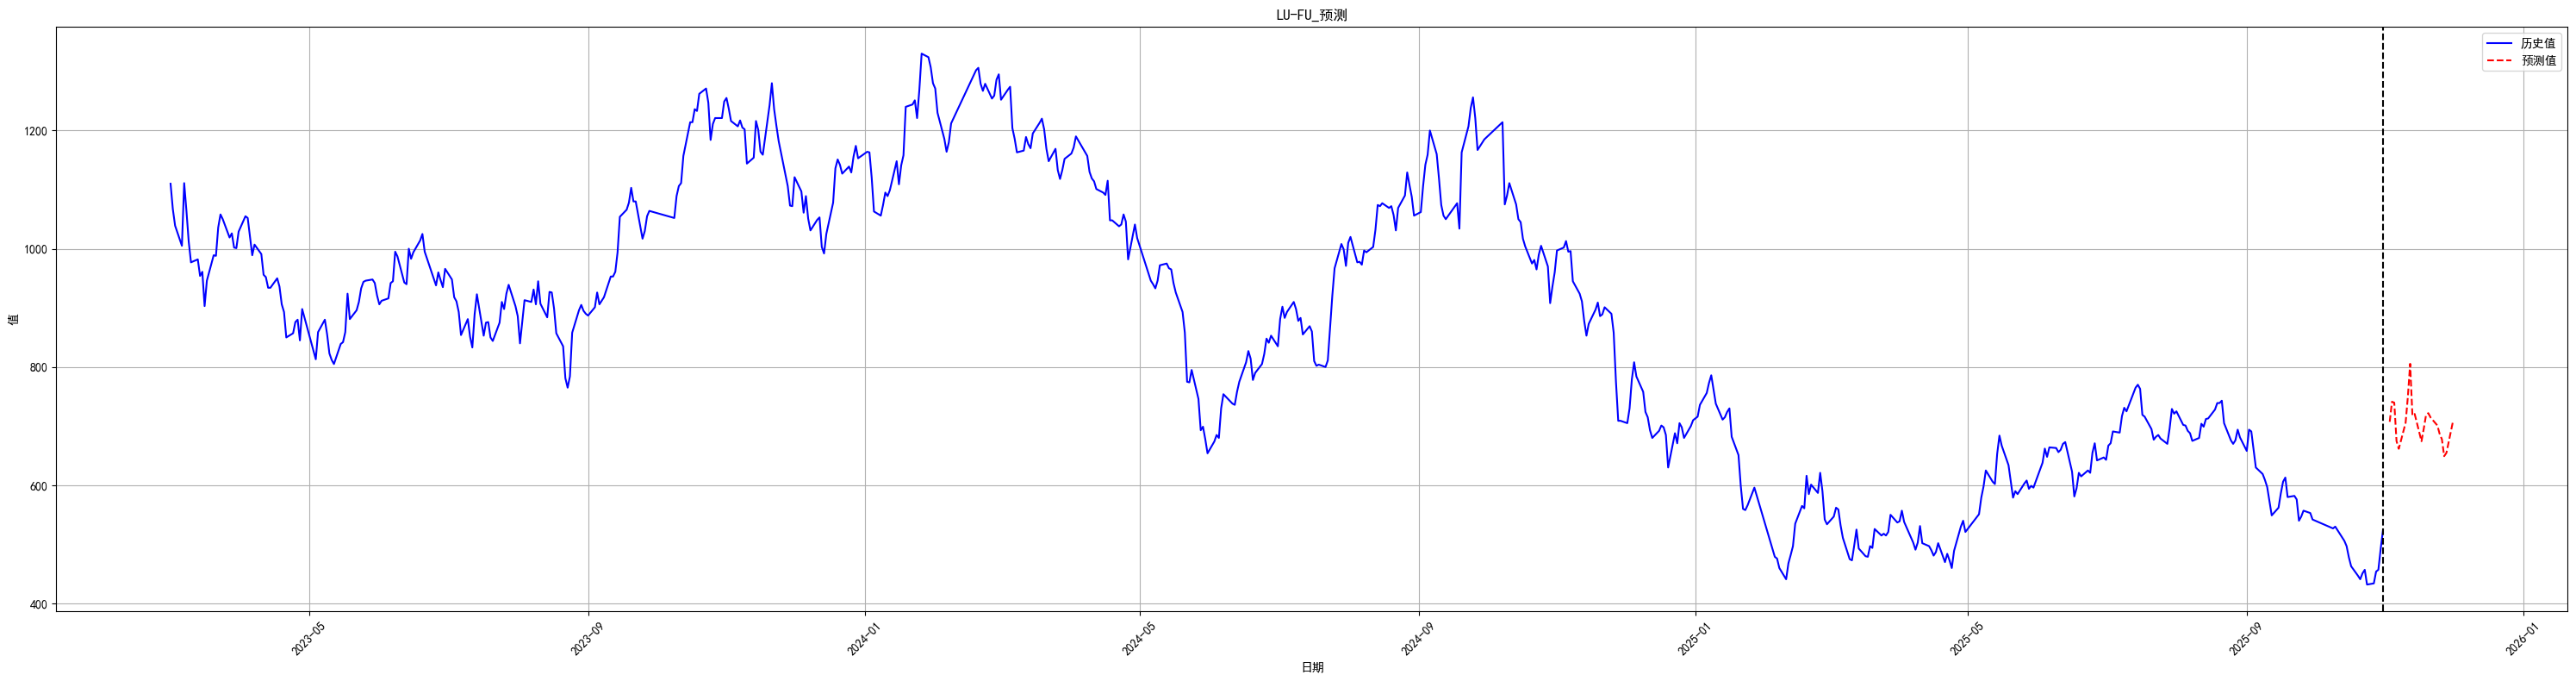

In [24]:
last_actual_date = sheet_daily_combined[sheet_daily_combined['LU-FU（期货指数）'].notna()]['Date'].max()
plt.figure(figsize=(30, 8))
historical = sheet_daily_combined[sheet_daily_combined['Date'] <= last_actual_date]
plt.plot(historical['Date'], historical['LU-FU（期货指数）'], label='历史值', color='blue')
forecast = sheet_daily_combined[sheet_daily_combined['Date'] > last_actual_date]
plt.plot(forecast['Date'], forecast['LU-FU_预测'], label='预测值', color='red', linestyle='--')
# 设置图形格式
avline_date = pd.to_datetime(last_actual_date)
plt.axvline(x=avline_date, color='black', linestyle='--')
plt.legend()
plt.title('LU-FU_预测')
plt.xlabel('日期')
plt.ylabel('值')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.show()


In [25]:
merged_df_daily_combined = sheet_daily_combined[['Date', 'LU-FU（期货指数）']].copy()
merged_df_daily_combined['LU-FU_预测'] = None
mask = sheet_daily_combined['Date'] > last_actual_date
merged_df_daily_combined.loc[mask, 'LU-FU_预测'] = sheet_daily_combined.loc[mask, 'LU-FU_预测']
merged_df_daily_combined = merged_df_daily_combined.sort_values('Date', ascending=False)
merged_df_daily_combined = merged_df_daily_combined.rename(columns={'LU-FU（期货指数）': '真实值','LU-FU_预测': '预测值'})
merged_df_daily_combined['Date'] = merged_df_daily_combined['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily_combined

,Date,真实值,预测值
668,2025/12/01,NaN,710.307179
667,2025/11/28,NaN,654.795353
666,2025/11/27,NaN,649.154705
665,2025/11/26,NaN,677.700608
664,2025/11/25,NaN,687.004393
...,...,...,...
4,2023/03/07,1111.0,None
3,2023/03/06,1005.0,None
2,2023/03/03,1039.0,None
1,2023/03/02,1067.0,None


In [26]:
merged_df_monthly_combined = sheet_daily_combined[['Date', 'LU-FU（期货指数）']].copy()
merged_df_monthly_combined['LU-FU_预测'] = None
# 只保留2025年之后的预测值
mask = pd.to_datetime(sheet_daily_combined['Date']) >= '2025-01-01'
merged_df_monthly_combined.loc[mask, 'LU-FU_预测'] = sheet_daily_combined.loc[mask, 'LU-FU_预测']

merged_df_monthly_combined = merged_df_monthly_combined.rename(columns={'LU-FU（期货指数）': '真实值','LU-FU_预测': '预测值'})
merged_df_monthly_combined['Date'] = pd.to_datetime(merged_df_monthly_combined['Date'])
merged_df_monthly_combined = merged_df_monthly_combined.resample('ME', on='Date').mean()
merged_df_monthly_combined = merged_df_monthly_combined.sort_values('Date', ascending=False)
merged_df_monthly_combined = merged_df_monthly_combined[merged_df_monthly_combined.index >= '2024-01-01']
merged_df_monthly_combined = merged_df_monthly_combined.reset_index()
merged_df_monthly_combined['Date'] = merged_df_monthly_combined['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly_combined


,Date,真实值,预测值
0,2025/12/31,NaN,710.307179
1,2025/11/30,NaN,705.920917
2,2025/10/31,476.529412,476.52224
3,2025/09/30,596.590909,596.584281
4,2025/08/31,702.000000,701.993886
5,2025/07/31,705.913043,705.906981
6,2025/06/30,641.500000,641.49305
7,2025/05/31,608.421053,608.4136
8,2025/04/30,504.190476,504.182934
9,2025/03/31,514.619048,514.611983


In [27]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "LU-FU（期货指数）拟合残差/新加坡高低硫燃料油价差"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [28]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "LU-FU（期货指数）拟合残差/新加坡高低硫燃料油价差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


---

In [29]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "LU-FU（期货指数）"

# 调用函数更新数据
success = update_excel_data(merged_df_daily_combined, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [30]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "LU-FU（期货指数）"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly_combined, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
